In [1]:
project_dir = "/Users/joannarownicka/software/vad"
os.chdir(project_dir)

In [2]:
import numpy as np
import os
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from lhotse import LilcomFilesWriter

from lhotse.features import Fbank, FeatureSetBuilder
from lhotse.cut import CutSet, SupervisionSet
from lhotse.dataset.sampling import SingleCutSampler, BucketingSampler
from lhotse.dataset.vad import VadDataset

from torch.utils.data import DataLoader

from preprocessing import prepare_vad_dataset
from models.dnn import DNN

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
root_dir = Path('evaluation/data')
corpus_dir = root_dir / 'vad_data/'
output_dir = root_dir / 'vad_data_nb/'

In [4]:
cuts = CutSet.from_json(output_dir / 'cuts_80.json.gz')
cuts.describe()

Cuts count: 957
Total duration (hours): 3.3
Speech duration (hours): 2.6 (80.6%)
***
Duration statistics (seconds):
mean    12.3
std      3.9
min      1.4
25%     11.1
50%     13.9
75%     15.1
max     17.2
dtype: float64


In [5]:
# Shuffle data but keep seed fixed, split into 80/10/10
#cuts_train, cuts_dev_eval = train_test_split(cuts, train_size=0.8, random_state=0)
#cuts_dev, cuts_eval = train_test_split(cuts_dev_eval, train_size=0.5, random_state=0)

cuts = cuts.shuffle()
vad_manifests = prepare_vad_dataset.prepare_vad_dataset(corpus_dir, output_dir)

train_ratio = 0.8

num_total = len(vad_manifests["supervisions"])
stop_train_idx = int(np.floor(num_total * train_ratio))
stop_dev_idx = int((num_total - stop_train_idx) // 2 + stop_train_idx)

train_ids, dev_ids, eval_ids = [], [], []
counter = 0
for sup_seg in vad_manifests["supervisions"]:
    id = sup_seg.to_dict()["id"]
    if counter < stop_train_idx:
        train_ids.append(id)
    elif counter < stop_dev_idx:
        dev_ids.append(id)
    else:
        eval_ids.append(id)
    counter += 1

assert train_ids[-1] != dev_ids[0]
assert dev_ids[-1] != eval_ids[0]

cuts_train = cuts.subset(supervision_ids=train_ids)
cuts_dev = cuts.subset(supervision_ids=dev_ids)
cuts_eval = cuts.subset(supervision_ids=eval_ids)

cuts_train.describe()
cuts_dev.describe()
cuts_eval.describe()


Cuts count: 766
Total duration (hours): 2.6
Speech duration (hours): 2.1 (80.6%)
***
Duration statistics (seconds):
mean    12.4
std      3.9
min      1.6
25%     11.2
50%     13.9
75%     15.1
max     16.9
dtype: float64
Cuts count: 95
Total duration (hours): 0.3
Speech duration (hours): 0.3 (79.9%)
***
Duration statistics (seconds):
mean    12.4
std      4.1
min      1.4
25%     11.3
50%     13.9
75%     15.1
max     17.2
dtype: float64
Cuts count: 98
Total duration (hours): 0.3
Speech duration (hours): 0.3 (79.4%)
***
Duration statistics (seconds):
mean    12.2
std      4.0
min      2.1
25%      9.5
50%     13.8
75%     15.1
max     16.4
dtype: float64


In [11]:
vad_dataset = VadDataset()

train_sampler = SingleCutSampler(cuts_train, shuffle=False, max_cuts=100)
dev_sampler = SingleCutSampler(cuts_dev, shuffle=False, max_cuts=100)
eval_sampler = SingleCutSampler(cuts_eval, shuffle=False, max_cuts=100)

train_dloader = DataLoader(vad_dataset, sampler=train_sampler, batch_size=None)
dev_dloader = DataLoader(vad_dataset, sampler=dev_sampler, batch_size=None)
eval_dloader = DataLoader(vad_dataset, sampler=eval_sampler, batch_size=None)

cut_ids = next(iter(dev_sampler))
sample = vad_dataset[cut_ids]

In [13]:
learning_rate = 1e-4
weight_decay = 1e-4

model_id = "dnn_ce_fbank80_ignoreindex"
input_size = sample['inputs'][0].shape[1]
log_dir = Path('storage/models') / model_id

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DNN(input_size=input_size, hidden_size=256, num_classes=2).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=-100)

#optim = torch.optim.Adam(model.parameters())
#                       lr=learning_rate, weight_decay=weight_decay)
                        
optim = torch.optim.SGD(model.parameters(), lr=learning_rate,
                        weight_decay=weight_decay)

def binary_acc(y_pred, y_test): 
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc, y_pred_tag


train_acc = []
valid_acc = []
for epoch in range(1):
    # training
    acc = []
    model.train()
    train_dloader.sampler.set_epoch(epoch)

    for batch_idx, data in enumerate(train_dloader):

        inputs = data["inputs"].reshape(-1,input_size)
        targets = data["is_voice"].reshape(-1,1).view(-1)
                
        out = model(inputs.to(device))
        loss = criterion(out, targets.long()) #ce
        model_acc, _ = binary_acc(out, targets.unsqueeze(1).to(device))

        if batch_idx % 10 == 0:
            print(f'Batch {batch_idx} => loss {loss}')
        optim.zero_grad()
        loss.backward()
        acc.append(model_acc)
        norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optim.step()
        t_r = loss.item()
        
    train_acc.append(np.mean(acc))

    # validation
    acc = []
    model.eval()
    for data in dev_dloader:
        inputs = data["inputs"].reshape(-1,input_size)
        targets = data["is_voice"].reshape(-1,1).view(-1)
        out = model(inputs.to(device))
        model_acc = binary_acc(out, targets.unsqueeze(1).to(device))
        acc.append(model_acc)
    valid_acc.append(np.mean(acc))
    print(f"epoch: {epoch}, train acc: {train_acc[-1]:.3f}, dev acc: {valid_acc[-1]:.3f}, loss:{t_r:.3f}")
    torch.save({'epoch': epoch + 1, 'state_dict': model.state_dict(),
        'optimizer': optim.state_dict()},
        f'{log_dir}/checkpoint_{epoch}.pth')
                    

tensor(86.)
Batch 0 => loss 0.622424840927124
tensor(80.)
tensor(81.)
tensor(78.)
tensor(80.)
tensor(75.)
tensor(79.)
tensor(77.)


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [182]:
def smooth_predictions(
    preds: List[float], 
    smooth_num_frames: int
) -> List[float]:

    """
        Returns smoothed model predictions.

        :param preds: List[float], a list of predictions with values in {0.0, 1.0}
        :param smooth_num_frames: int, number of frames to use for smoothing
        :return: List[float], a list of smoothed predictions with values in {0.0, 1.0}
    """
    
    smoothed_preds = []
    for i in range(smooth_num_frames - 1, len(preds), smooth_num_frames):
        cur_pred = preds[i]
        if cur_pred == preds[i - 1] == preds[i - 2]:
            smoothed_preds.extend(smooth_num_frames * [cur_pred])
        else:
            if len(smoothed_preds) > 0:
                smoothed_preds.extend(smooth_num_frames * [smoothed_preds[-1]])
            else:
                smoothed_preds.extend(smooth_num_frames * [0.0])
    smoothed_preds = (smooth_num_frames - 1) * [0.0] + smoothed_preds
    
    # Hangover (delayed transition from speech to non-speech)
    n = 0
    while n < len(smoothed_preds):
        cur_pred = smoothed_preds[n]
        if cur_pred == 1.0:
            if n > 0:
                smoothed_preds[n - 1] = 1.0
            if n < len(smoothed_preds) - 1:
                smoothed_preds[n + 1] = 1.0
            n += 2
        else:
            n += 1
    
    return smoothed_preds


In [213]:
pred_list = []
gold_list = []

model.eval()
with torch.no_grad():
    for data in eval_dloader:
        
        inputs_eval = data["inputs"].reshape(-1,input_size)
        targets_eval = data["is_voice"].reshape(-1,1).view(-1)

        out = model(inputs_eval.to(device))
        model_acc, pred_tag = binary_acc(out, targets_eval.unsqueeze(1).to(device))

        pred_val = [ float(np.argmax(item)) for item in pred_tag ]
        pred_list.extend(pred_val)
        gold_list.extend(targets.tolist())

TypeError: iteration over a 0-d tensor

In [210]:
smoothed_pred_list = smooth_predictions(pred_list, smooth_num_frames=3)

In [211]:
print(set(gold_list))
print(set(smoothed_pred_list))

print(confusion_matrix(gold_list, smoothed_pred_list))
print(classification_report(gold_list, smoothed_pred_list))

{tensor(0.), tensor(-100.), tensor(1.), tensor(0.), tensor(-100.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(-100.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(-100.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(-100.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(-100.), tensor(1.), tensor(-100.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(-100.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(-100.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(-100.), tensor(1.), tensor(0.), tensor(0.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(-100.), tensor(1.), tensor(1.), tensor(1.), tensor

/Users/joannarownicka/miniconda3/envs/vad/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joannarownicka/miniconda3/envs/vad/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joannarownicka/miniconda3/envs/vad/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

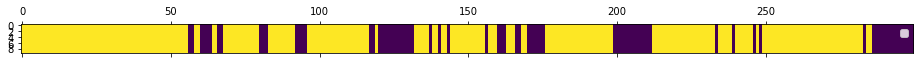

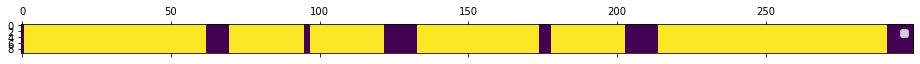

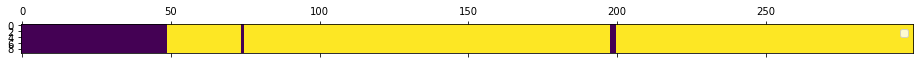

In [186]:
label_height = 10

vad_label = torch.stack([torch.Tensor(pred_list[:300]) for i in range(label_height)]).reshape(label_height, 300)
plt.matshow(vad_label)
plt.legend("Predictions")

vad_label = torch.stack([torch.Tensor(smoothed_pred_list[:300]) for i in range(label_height)]).reshape(label_height, 300)
plt.matshow(vad_label)
plt.legend("Smoothed predictions")

vad_label = torch.stack([torch.Tensor(gold_list[:300]) for i in range(label_height)]).reshape(label_height, 300)
plt.matshow(vad_label)
plt.legend("Targets")
